In [1]:
import warnings
from typing import Tuple, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve

In [2]:
data = pd.read_csv("data.csv")
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
x_train, x_valid = train_test_split(
    data[['TransactionAmt', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1']], train_size=0.70, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    data['isFraud'], train_size=0.70, shuffle=True, random_state=1,
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 70000 rows, 17 cols
x_valid.shape = 30000 rows, 17 cols


In [7]:
def fit_evaluate_model(estimator, x_train, y_train, x_valid, y_valid):
    
    estimator.fit(x_train, y_train)
    y_train_pred = estimator.predict_proba(x_train)[:, 1]
    y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

    train_score = roc_auc_score(y_train, y_train_pred)
    valid_score = roc_auc_score(y_valid, y_valid_pred)
    print(f"Model Score: train = {round(train_score, 4)}, valid = {round(valid_score, 4)}")

    return y_train_pred, y_valid_pred

In [8]:
forest = RandomForestClassifier(
    random_state=27
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    forest, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.9998, valid = 0.8984


In [15]:
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=forest,
    param_range=range(2, 15),
    param_name="max_depth",
    scoring="roc_auc",
    n_jobs=1,
    cv=3,
)

In [13]:
def plot_validation_curves(train_scores: np.array,
                           valid_scores: np.array,
                           figsize: Tuple[int, int] = (8, 8)
                          ):
    
    fig = plt.figure(figsize=figsize)

    #plt.subplot(121)
    plt.title("Validation Curves", size=15)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(train_scores, axis=1),
        label="train",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(train_scores, axis=1)-np.std(train_scores, axis=1),
        y2=np.mean(train_scores, axis=1)+np.std(train_scores, axis=1),
        alpha=0.25
    )
    #plt.subplot(121)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(valid_scores, axis=1),
        label="valid",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(valid_scores, axis=1)-np.std(valid_scores, axis=1),
        y2=np.mean(valid_scores, axis=1)+np.std(valid_scores, axis=1),
        alpha=0.25
    )
    plt.legend(loc="best", fontsize=14)
    plt.ylabel("roc_auc", size=15)

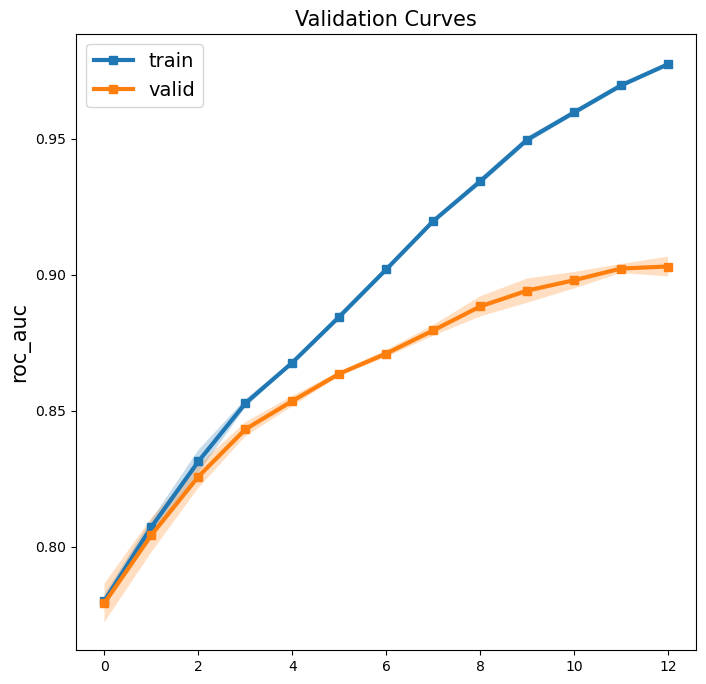

In [16]:
plot_validation_curves(
    train_scores, valid_scores
)

In [17]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx

In [18]:
def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores

In [19]:
def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [20]:
forest = RandomForestClassifier(
    n_estimators=500, max_depth=14, random_state=27
)
forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=14, n_estimators=500, random_state=27)

In [37]:
np.random.seed(27)
scores = create_bootstrap_metrics(
    y_valid, y_valid_pred, roc_auc_score
)

/var/folders/4m/8dvsk5n16v393061q10pts6m0000gn/T/ipykernel_63813/573118077.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores, ax=axes[0], color="green", bins=20)


Text(0.5, 0, 'sample number')

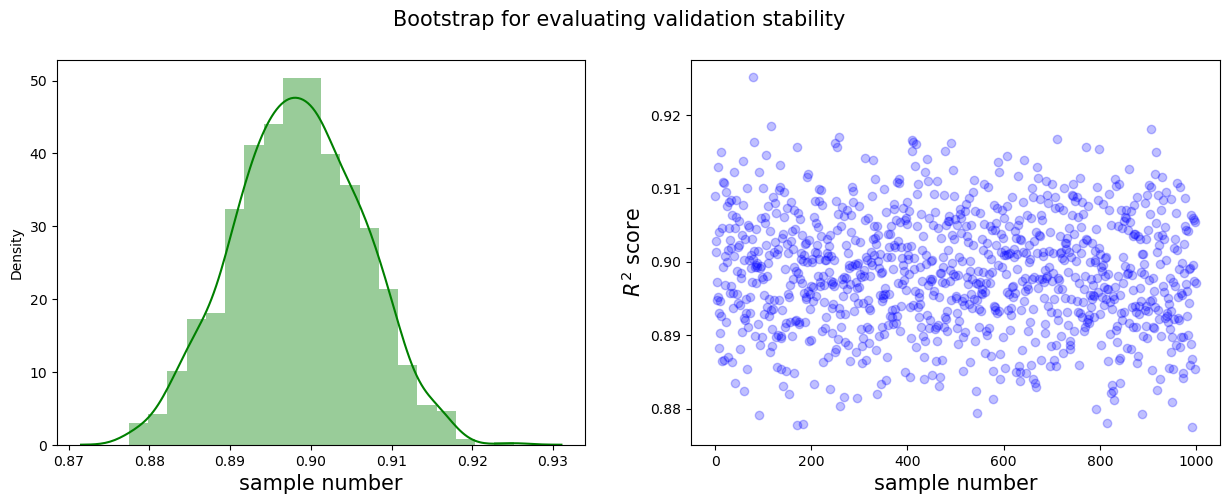

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)

In [39]:
calculate_confidence_interval(scores)

(0.8832313181156318, 0.9137045364207433)

In [41]:
width = confidence_interval[1] - confidence_interval[0]
width

0.02825538717670706

In [42]:
# Округление до сотых
width_rounded = round(width, 2)

print(f'{width_rounded=}')

width_rounded=0.03
